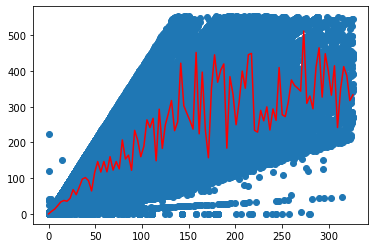

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define a function to remove outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = pd.read_csv('GasConsumption.csv', low_memory=False)

# Drop irrelevant columns
df.drop(['TDS #', 'EDP', 'RC Code', 'AMP #', 'UMIS BILL ID', 'Meter Number', 'Account Name', 'Location'], axis=1, inplace=True)

brooklyn_df = df.loc[df['Borough'] == 'BROOKLYN'].copy()
# Convert 'Current Charges' and 'Consumption (Therms)' to numeric
brooklyn_df['Current Charges'] = pd.to_numeric(brooklyn_df['Current Charges'], errors='coerce').astype(np.float64)
brooklyn_df['Consumption (Therms)'] = pd.to_numeric(brooklyn_df['Consumption (Therms)'], errors='coerce').astype(np.float64)

# Drop rows with NaN values
brooklyn_df = brooklyn_df.dropna(subset=['Consumption (Therms)', 'Current Charges'])
brooklyn_df = brooklyn_df.loc[(brooklyn_df['Current Charges'] >= 0) & (brooklyn_df['Consumption (Therms)'] >= 0)].copy()

# Remove rows with negative values
brooklyn_df = brooklyn_df.loc[(brooklyn_df['Current Charges'] >= 0) & (brooklyn_df['Consumption (Therms)'] >= 0)]

# Remove outliers
brooklyn_df = remove_outliers(brooklyn_df, 'Current Charges')
brooklyn_df = remove_outliers(brooklyn_df, 'Consumption (Therms)')


features = ['Current Charges', '# days']
X = brooklyn_df['Current Charges']
y = brooklyn_df['Consumption (Therms)']
X = np.reshape(X, (-1, 1))
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

X_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)


y_vals = model.predict(X_vals)

plt.scatter(X, y)
plt.plot(X_vals, y_vals, color='red')
plt.show()


Current Charges    0
# days             0
dtype: int64


<Figure size 864x360 with 0 Axes>

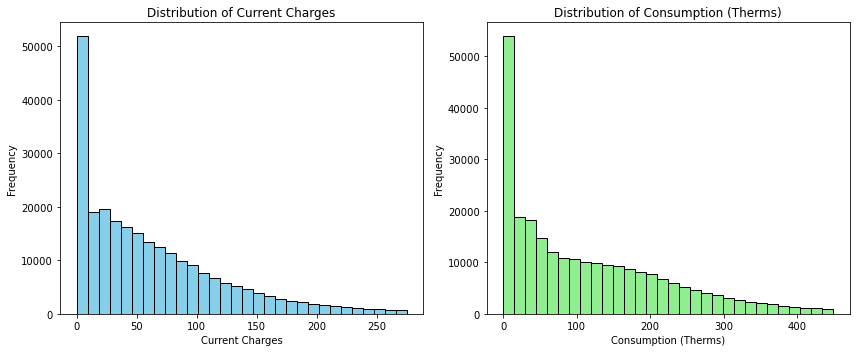

(Log) Mean Squared Error: 0.8952555583790904
(Log) R-squared: 0.7271211513151197
Mean square error: 9149.229575374024
R-squared: -1.0408767473191447
Coefficients: [ 2.08987554e+00 -9.48005035e-02 -6.82028479e-01  1.36823046e-02
  6.97328264e-04]
Intercept: 4.52441252452257


/home/kaan/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


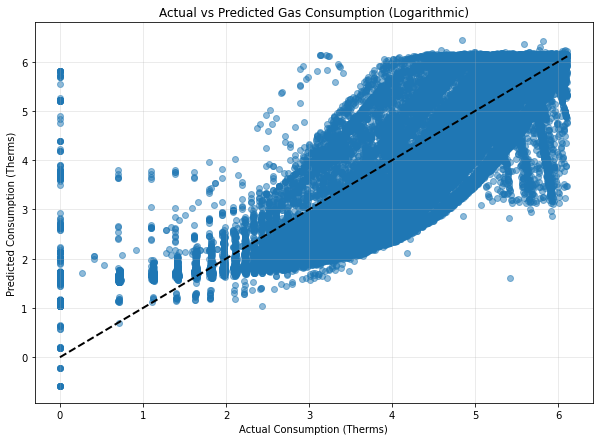

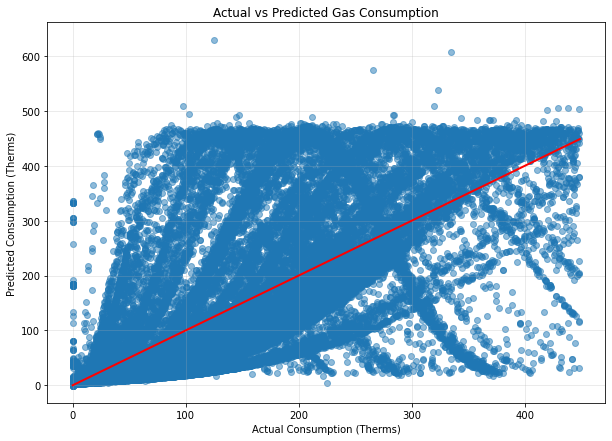

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

def mean_square_error(y_true, y_pred):
    """
    Calculate the mean square error of a regression model.

    Parameters:
    y_true (array-like): True values for the target variable.
    y_pred (array-like): Predicted values for the target variable.

    Returns:
    float: Mean square error of the model.
    """
    return np.mean((y_true - y_pred) ** 2)

# Define a function to remove outliers based on the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Load the data
df = pd.read_csv('GasConsumption.csv', low_memory=False) # Replace with the actual path to your CSV file

# Drop irrelevant columns
df.drop(['TDS #', 'EDP', 'RC Code', 'AMP #', 'UMIS BILL ID', 'Meter Number', 'Account Name', 'Location'], axis=1, inplace=True)

# Filter for rows where 'Borough' is 'BROOKLYN'
brooklyn_df = df.loc[df['Borough'] == 'BROOKLYN'].copy()

# Convert 'Current Charges' and 'Consumption (Therms)' to numeric
brooklyn_df['Current Charges'] = pd.to_numeric(brooklyn_df['Current Charges'], errors='coerce').astype(np.float64)
brooklyn_df['Consumption (Therms)'] = pd.to_numeric(brooklyn_df['Consumption (Therms)'], errors='coerce').astype(np.float64)

# Drop rows with NaN values
brooklyn_df = brooklyn_df.dropna(subset=['Consumption (Therms)', 'Current Charges'])
brooklyn_df = brooklyn_df.loc[(brooklyn_df['Current Charges'] >= 0) & (brooklyn_df['Consumption (Therms)'] >= 0)].copy()

#Converting dates to dateTime objects
brooklyn_df['Service Start Date'] = pd.to_datetime(brooklyn_df['Service Start Date'], errors='coerce')
brooklyn_df['Service End Date'] = pd.to_datetime(brooklyn_df['Service End Date'], errors='coerce')
# Create seasonal features (assuming Northern Hemisphere seasons)
brooklyn_df['Start Month'] = brooklyn_df['Service Start Date'].dt.month
brooklyn_df['Winter'] = ((brooklyn_df['Start Month'] == 12) | 
                         (brooklyn_df['Start Month'] == 1) | 
                         (brooklyn_df['Start Month'] == 2)).astype(int)
brooklyn_df['Spring'] = ((brooklyn_df['Start Month'] == 3) | 
                         (brooklyn_df['Start Month'] == 4) | 
                         (brooklyn_df['Start Month'] == 5)).astype(int)
brooklyn_df['Summer'] = ((brooklyn_df['Start Month'] == 6) | 
                         (brooklyn_df['Start Month'] == 7) | 
                         (brooklyn_df['Start Month'] == 8)).astype(int)
brooklyn_df['Fall'] = ((brooklyn_df['Start Month'] == 9) | 
                       (brooklyn_df['Start Month'] == 10) | 
                       (brooklyn_df['Start Month'] == 11)).astype(int)
# Handle categorical variables
brooklyn_df = pd.get_dummies(brooklyn_df, columns=['Rate Class', 'Development Name', 'Meter Scope'], drop_first=True)

# Select features for the model
features = ['Current Charges', '# days']
print(brooklyn_df[features].isna().sum())


# Remove outliers
brooklyn_df = remove_outliers(brooklyn_df, 'Current Charges')
brooklyn_df = remove_outliers(brooklyn_df, 'Consumption (Therms)')

# Remove rows with negative values
brooklyn_df = brooklyn_df.loc[(brooklyn_df['Current Charges'] >= 0) & (brooklyn_df['Consumption (Therms)'] >= 0)]



# Plotting the distribution of 'Current Charges' and 'Consumption (Therms)'
plt.figure(figsize=(12, 5))

# Plotting the distribution of 'Current Charges' and 'Consumption (Therms)'
plt.figure(figsize=(12, 5))

# Distribution of 'Current Charges'
plt.subplot(1, 2, 1)
plt.hist(brooklyn_df['Current Charges'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Current Charges')
plt.xlabel('Current Charges')
plt.ylabel('Frequency')

# Distribution of 'Consumption (Therms)'
plt.subplot(1, 2, 2)
plt.hist(brooklyn_df['Consumption (Therms)'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Consumption (Therms)')
plt.xlabel('Consumption (Therms)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Prepare the data
X = brooklyn_df[features] # Features
y = brooklyn_df['Consumption (Therms)'] # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Create a pipeline with Polynomial Features and Linear Regression
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), # Add polynomial features
    ('regressor', LinearRegression())
])
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#Transform min and max values
y_min_log = np.min(y_test_log)
y_max_log = np.max(y_test_log)

#X_train_charges = X_train['Current Charges'].values.reshape()

# Train the model with the original target
model.fit(X_train, y_train_log)

# Predict on the testing data
y_pred_log = model.predict(X_test)
y_pred = np.expm1(model.predict(X_test))

# print(brooklyn_df['Current Charges'].describe())

# print(brooklyn_df)

# Calculate the MSE and print R-squared
mse_log = mean_square_error(y_test_log, y_pred_log)
r_squared_log = model.score(X_test, y_test_log)
mse = mean_square_error(y_test, y_pred)
r_squared = model.score(X_test, y_test)
print(f'(Log) Mean Squared Error: {mse_log}')
print(f"(Log) R-squared: {r_squared_log}")
print(f"Mean square error: {mse}")
print(f"R-squared: {r_squared}")

# Get the model's coefficients and intercept from the 'regressor' step of the pipeline
regressor = model.named_steps['regressor']
print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

# Generate predictions for plotting
X_min, X_max = X['Current Charges'].min(), X['Current Charges'].max()
X_plot_charges = np.linspace(X_min, X_max, 100).reshape(-1, 1)
median_days = X['# days'].median()
X_plot_full = np.column_stack([
    X_plot_charges,
    np.full_like(X_plot_charges,median_days)
])
y_plot = model.predict(X_plot_full)

# Create an actual vs predicted plot (Logarithmic)
plt.figure(figsize=(10, 7))
plt.scatter(y_test_log, y_pred_log, alpha=0.5)
plt.plot([y_min_log, y_max_log], [y_min_log, y_max_log], 'k--', lw=2)
plt.xlabel('Actual Consumption (Therms)')
plt.ylabel('Predicted Consumption (Therms)')
plt.title('Actual vs Predicted Gas Consumption (Logarithmic)')
plt.grid(True, alpha=0.3)
plt.show()

# # Create an actual vs predicted plot
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Consumption (Therms)')
plt.ylabel('Predicted Consumption (Therms)')
plt.title('Actual vs Predicted Gas Consumption')
plt.grid(True, alpha=0.3)
plt.show()

